Model teste from https://buildingenergygeeks.org/a-simple-rc-model-python.html

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import pandas as pd
from scipy.interpolate import interp1d

In [2]:
path = r"C:\Users\Alexandra\Documents\TEE-etoile\ProCom\donnes_15days_RC.csv"
df = pd.read_csv(path, delimiter = ',')

df['P'] = df['P']
df['Radiation'] = df['Radiation']
df['Tin'] = df['Tin']

print(df.head)


<bound method NDFrame.head of       Tex   Tin       P  Radiation
0    13.6  16.0   709.0        0.0
1    13.1  16.0   695.0        0.0
2    12.7  16.0   712.0        0.0
3    12.2  16.0   737.0        0.0
4    11.6  16.0   768.0        0.0
..    ...   ...     ...        ...
331  10.5  16.0   824.0        0.0
332   9.8  16.0   877.0        0.0
333   9.1  16.0   949.0        0.0
334   8.1  16.0  1040.0        0.0
335   7.4  16.0  1118.0        0.0

[336 rows x 4 columns]>


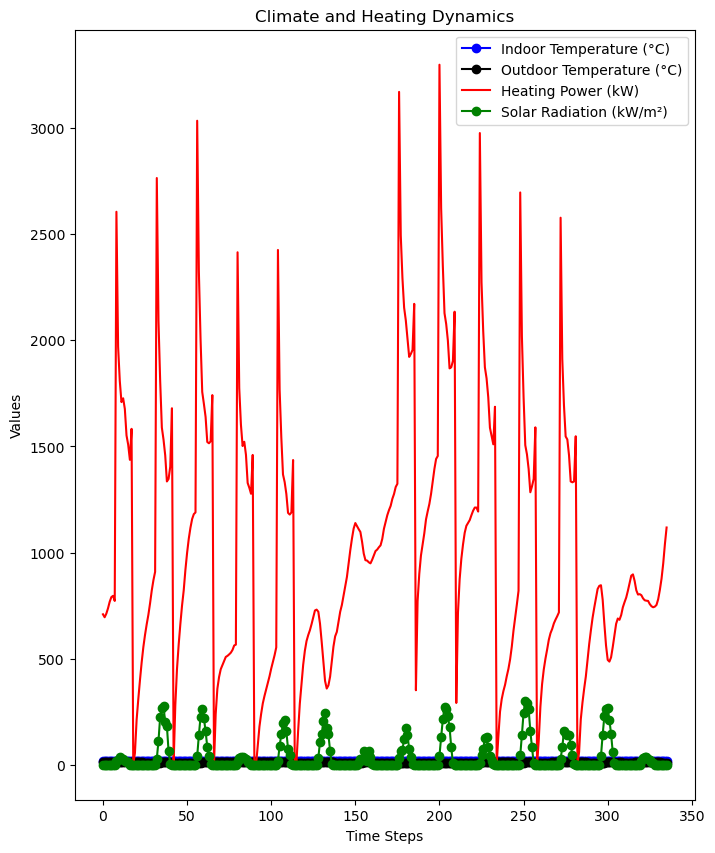

In [3]:
fig, ax = plt.subplots(figsize=(8, 10))


ax.plot(df['Tin'], marker='o', color='blue', label='Indoor Temperature (°C)')
ax.plot(df['Tex'], marker='o', color='black', label='Outdoor Temperature (°C)')
ax.plot(df['P'], color='red', label='Heating Power (kW)')
ax.plot(df['Radiation'], marker='o', color='green', label='Solar Radiation (kW/m²)')
ax.set_xlabel("Time Steps")
ax.set_ylabel("Values")
ax.set_title("Climate and Heating Dynamics")
ax.legend()

plt.show()

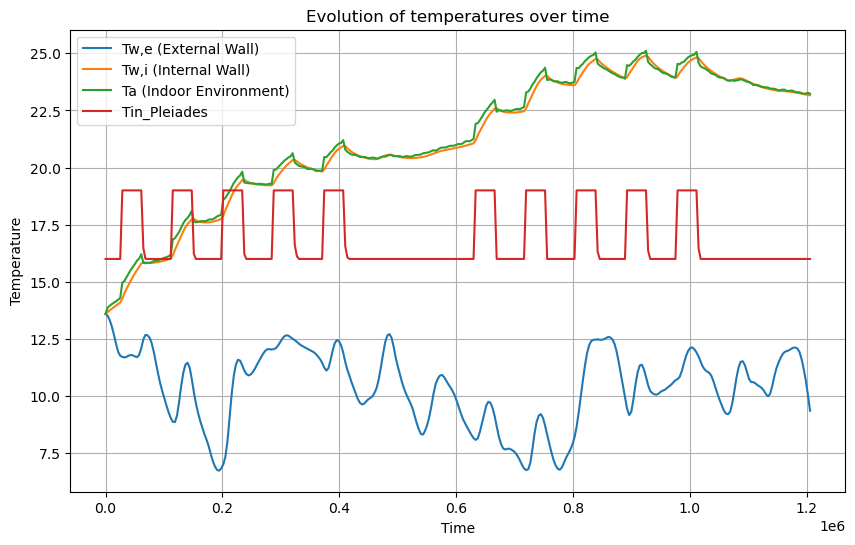

In [4]:
###------------- Variables-----------------####

# Surface areas
As = 95         # Surface flor(m2)
Aw = 110.7      # Surface area of walls (m2)
Afen = 8        # Surface area of windows (m2) 
Ae = 110        # External surface area of walls (m2)
taufen = 0.90   # Transmition coefficient 
alpha_e = 0.2   # Absortion coeffient external wall
alpha_i = 0.4   # Absortion coeffient internal wall

# Thermal properties
Ci = 280.0e3    # Thermal capacity of air (J/K)
Cw = 62.0e6   # Thermal capacity of walls (J/K)
Ke = 3.2e3      # External thermal resistance (kW/K) 
Kw = 25.0  # Thermal resistance of walls (kW/K)
Ki = 3.2e3      # Internal thermal resistance (kW/K)
m_dot = 55.0  # Infiltration rate (W/K)

# Initial conditions from data
Twe = df['Tex'].iloc[0]     # External wall temperature
Twi = df['Tex'].iloc[0]     # Internal wall temperature
Ta = df['Tex'].iloc[0]      # Air temperature
X0 = [Ta, Twi, Twe]         # Initial conditions vectori, Twe]   # Initial condition

# Extract data series
E = df['Radiation'].values
Tex = df['Tex'].values
Tin = df['Tin'].values
P = df['P'].values
###------------- MODELO -----------------####


MATRIX_A = [
    [-(m_dot + Ki) / Ci, Ki/Ci, 0],
    [2 * Ki / Cw, -2 * (Kw + Ki) / Cw, 2 * Kw / Cw],
    [0, 2 * Kw / Cw, -2 * (Ke + Kw) / Cw]
]

MATRIX_B = [
    [0, 0, m_dot / Ci],
    [0, 2 / Cw , 0],
    [2 / Cw, 0, 2 * Ke / Cw ]
]


E_func = interp1d(np.arange(len(E)), E, kind='linear', fill_value="extrapolate")
Tex_func = interp1d(np.arange(len(Tex)), Tex, kind='linear', fill_value="extrapolate")
P_func = interp1d(np.arange(len(P)), P, kind='linear', fill_value="extrapolate")

def RC_model(t, X, MATRIX_A, MATRIX_B):

    ind = t/3600
    
    # Evaluar las señales en el tiempo t
    E_t = E_func(ind)
    Tex_t = Tex_func(ind)
    P_t = P_func(ind)

    Ge_t = alpha_e * Ae / 2 * E_t if E_t != 0 else 0
    Gi_t = taufen * alpha_i * Afen * E_t

    D = np.array([P_t / Ci, 0, 0])
    C = np.array([Ge_t, Gi_t, Tex_t ])

    return MATRIX_A @ X + MATRIX_B @ C + D

# Solving System
t_span = [0, len(E)*3600] #seconds
t_eval = np.arange(0, len(E)*3600, 3600)

sol = solve_ivp(RC_model, t_span, X0, t_eval=t_eval, args=(MATRIX_A, MATRIX_B))
time = sol.t
T_a, T_w_i, T_w_e = sol.y



plt.figure(figsize=(10, 6))
plt.plot(time, T_w_e, label="Tw,e (External Wall)")
plt.plot(time, T_w_i, label="Tw,i (Internal Wall)")
plt.plot(time, T_a, label="Ta (Indoor Environment)")
plt.plot(time, Tin[:len(time)], label = 'Tin_Pleiades')
plt.xlabel("Time")
plt.ylabel("Temperature")
plt.title("Evolution of temperatures over time")
plt.legend()
plt.grid()
plt.show()

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import pandas as pd
from scipy.interpolate import interp1d
from scipy.optimize import minimize


path = r"C:\Users\Alexandra\Documents\TEE-etoile\ProCom\donnes_modele_RC.csv"
df = pd.read_csv(path, delimiter=',')


###------------- Variables-----------------####

# Surface areas
As = 95         # Surface flor(m2)
Aw = 110.7      # Surface area of walls (m2)
Afen = 8        # Surface area of windows (m2) 
Ae = 110        # External surface area of walls (m2)
taufen = 0.90   # Transmition coefficient 
alpha_e = 0.2   # Absortion coeffient external wall
alpha_i = 0.4   # Absortion coeffient internal wall

# Thermal properties
Ci = 280.0e3    # Thermal capacity of air (J/K)
Cw = 62.0e6   # Thermal capacity of walls (J/K)
Ke = 3.2e3      # External thermal resistance (kW/K) 
Kw = 25.0  # Thermal resistance of walls (kW/K)
Ki = 3.2e3      # Internal thermal resistance (kW/K)
m_dot = 55.0  # Infiltration rate (W/K)

# Initial conditions from data
Twe = df['Tex'].iloc[0]     # External wall temperature
Twi = df['Tex'].iloc[0]     # Internal wall temperature
Ta = df['Tex'].iloc[0]      # Air temperature
X0 = [Ta, Twi, Twe]         # Initial conditions vectori, Twe]   # Initial condition

# Extract data series
E = df['Radiation'].values
Tex = df['Tex'].values
Tin = df['Tin'].values
P = df['P'].values


def RC_model_for_optimization(Twe, Twi, Ta, E, Tex, P, params):
    Ci, Cw, Ke, Kw, Ki, m_dot = params

   
    MATRIX_A = np.array([
        [-(m_dot + Ki) / Ci, Ki / Ci, 0],
        [2 * Ki / Cw, -2 * (Kw + Ki) / Cw, 2 * Kw / Cw],
        [0, 2 * Kw / Cw, -2 * (Ke + Kw) / Cw]
    ])

    MATRIX_B = np.array([
        [0, 0, m_dot / Ci],
        [0, 2 / Cw, 0],
        [2 / Cw, 0, 2 * Ke / Cw]
    ])

    
    E_func = interp1d(t, E, kind='linear', fill_value="extrapolate")
    Tex_func = interp1d(t, Tex, kind='linear', fill_value="extrapolate")
    P_func = interp1d(t, P, kind='linear', fill_value="extrapolate")

    def RC_model(t, X):
        Ta, Twi, Twe = X
        ind = t / 3600
        E_t = max(E_func(ind), 1e-10)   # Avoid division by zero
        Tex_t = Tex_func(ind)
        P_t = P_func(ind)

        Ge_t = alpha_e * Ae/2 * E_t 
        Gi_t = taufen * alpha_i * Afen * E_t

        D = np.array([P_t / Ci, 0, 0])
        C = np.array([Ge_t, Gi_t, Tex_t])

        return MATRIX_A @ X + MATRIX_B @ C + D

    # Solve the system
    t_span = [0, 96*3600]  # Seconds
    t_eval = np.arange(0, 96*3600, 3600)
    #sol = solve_ivp(RC_model, t_span, X0, t_eval=t_eval, method='LSODA')
    sol = solve_ivp(RC_model, t_span, X0, t_eval=t_eval, method='RK45')
    
    return sol.y[0]  # Return simulated temperature (Ta)

def objective_function(params):
    Ta_simulated = RC_model_for_optimization(Twe, Twi, Ta, E, Tex, P, params)
    return np.sum((Ta_simulated - Tin) ** 2)

# Initial parameters
initial_params = [180.0e3, 50.0e6, 1e3, 45.0, 3.2e3, 100.0]

# Calculate temperature with initial parameters
Ta_initial = RC_model_for_optimization(Twe, Twi, Ta, E, Tex, P, initial_params)

# Restricciones de optimización
bounds = [
    (100e3, 1000e3),     #  Ci bounds
    (10e6, 200e6),       #  Cw bounds
    (0.1e3, 10e3),       #  Ke bounds
    (1, 1e3),            #  Kw bounds
    (0.1e3, 10e3),       #  Ki bounds
    (1, 1e3)             #  m_dot bounds
]

# Optimization with scipy minimize
result = minimize(
    objective_function,
    initial_params,
    method='L-BFGS-B',
    bounds=bounds,
    options={'maxiter': 100}  # Reducir el número máximo de iteraciones
)

# Calculate temperature with optimized parameters
Ta_optimized = RC_model_for_optimization(Twe, Twi, Ta, E, Tex, P, result.x)

# Print results
param_names = ['Ci', 'Cw', 'Ke', 'Kw', 'Ki', 'm_dot']
for name, value in zip(param_names, result.x):
    print(f"{name}: {value:.6f}")

# Create time array for x-axis
time = np.arange(len(Tin))
plt.figure(figsize=(12, 6))
plt.plot(time, Tin, label='Measured Temperature (Tin)', color='blue')
plt.plot(time, Ta_initial, label='Initial Parameters', color='red', linestyle='--')
plt.plot(time, Ta_optimized, label='Optimized Parameters', color='green', linestyle='-.')
plt.xlabel('Time Steps')
plt.ylabel('Temperature (°C)')
plt.title('Temperature Comparison: Measured vs Initial vs Optimized')
plt.legend()
plt.grid(True)
plt.show()

# Calculate and print MSE for both cases
mse_initial = np.mean((Ta_initial - Tin) ** 2)
mse_optimized = np.mean((Ta_optimized - Tin) ** 2)
print("\nMean Squared Error Comparison:")
print(f"Initial parameters MSE: {mse_initial:.6f}")
print(f"Optimized parameters MSE: {mse_optimized:.6f}")
print(f"Improvement: {((mse_initial - mse_optimized)/mse_initial * 100):.2f}%")


NameError: name 't' is not defined